In [6]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [7]:
import pathlib

# 로컬 데이터 경로 설정
data_dir = pathlib.Path("./dataset/")

# data_dir을 바로 사용하여 데이터를 불러올 수 있음

In [8]:
image_count = len(list(data_dir.glob('*/*.JPG'))+list(data_dir.glob('*/*.jpg')) )
print(image_count)

3354


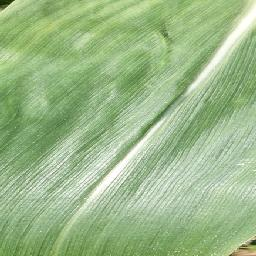

In [9]:
corn_healthy_datasets = list(data_dir.glob('Corn___healthy/*'))
PIL.Image.open(str(corn_healthy_datasets[0]))

In [10]:
# 매개변수 정의
batch_size = 32
img_height = 180
img_width = 180

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3354 files belonging to 3 classes.
Using 2684 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3354 files belonging to 3 classes.
Using 670 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy']


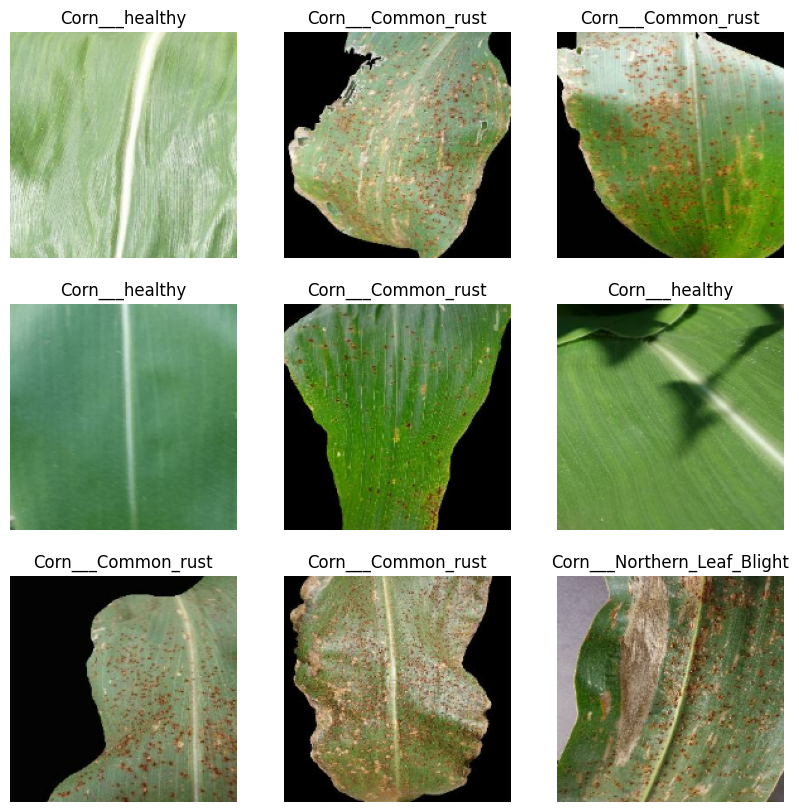

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# 모델 훈련하기

In [32]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
84/84 [==============================] - 11s 130ms/step - loss: 0.0270 - accuracy: 0.9952 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 2/20
84/84 [==============================] - 12s 141ms/step - loss: 0.0108 - accuracy: 0.9978 - val_loss: 0.0041 - val_accuracy: 0.9985
Epoch 3/20
84/84 [==============================] - 10s 124ms/step - loss: 0.0081 - accuracy: 0.9974 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 4/20
84/84 [==============================] - 11s 133ms/step - loss: 0.0281 - accuracy: 0.9918 - val_loss: 0.1255 - val_accuracy: 0.9806
Epoch 5/20
84/84 [==============================] - 11s 132ms/step - loss: 0.0138 - accuracy: 0.9974 - val_loss: 5.7575e-04 - val_accuracy: 1.0000
Epoch 6/20
84/84 [==============================] - 11s 126ms/step - loss: 0.0059 - accuracy: 0.9989 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 7/20
84/84 [==============================] - 10s 124ms/step - loss: 0.0090 - accuracy: 0.9978 - val_loss: 0.0162 - val_accuracy: 0.

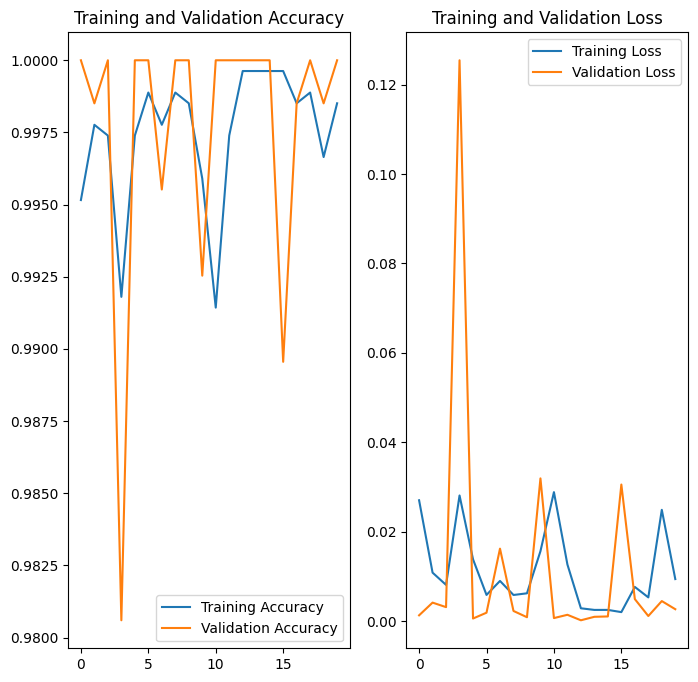

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

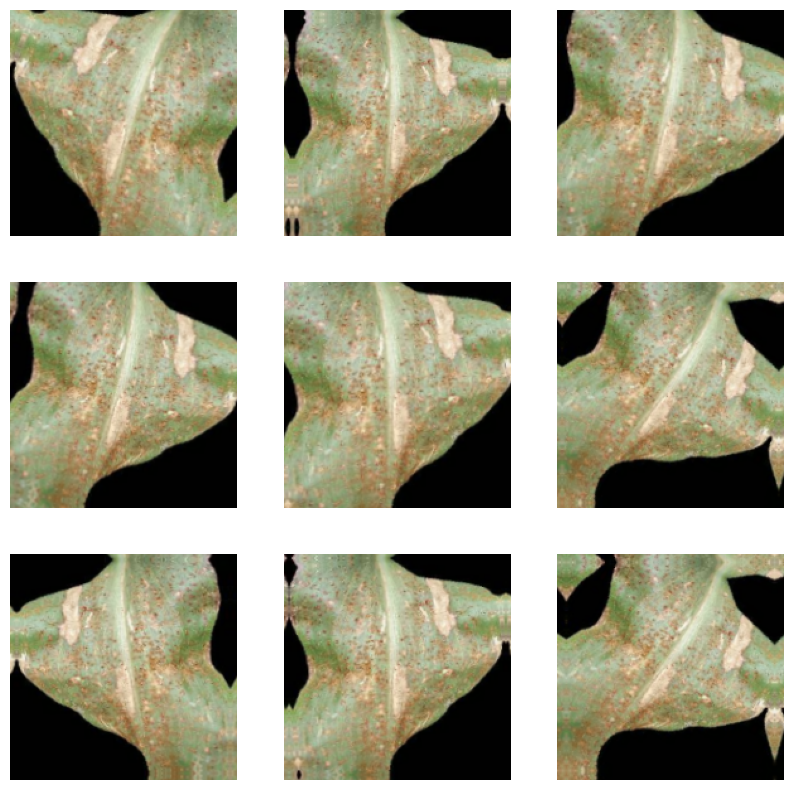

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [23]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [26]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


84/84 [==============================] - 13s 148ms/step - loss: 0.4560 - accuracy: 0.8316 - val_loss: 0.0373 - val_accuracy: 0.9910
Epoch 2/15
84/84 [==============================] - 12s 138ms/step - loss: 0.0891 - accuracy: 0.9721 - val_loss: 0.0351 - val_accuracy: 0.9910
Epoch 3/15
84/84 [==============================] - 12s 138ms/step - loss: 0.0617 - accuracy: 0.9862 - val_loss: 0.0083 - val_accuracy: 0.9985
Epoch 4/15
84/84 [==============================] - 12s 139ms/step - loss: 0.0338 - accuracy: 0.9940 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 5/15
84/84 [==============================] - 12s 138ms/step - loss: 0.0393 - accuracy: 0.9922 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 6/15
84/84 [==============================] - 12s 139ms/step - loss: 0.0225 - accuracy: 0.9940 - val_loss: 0.0057 - val_accuracy: 0.9970
Epoch 7/15
84/84 [==============================] - 12s 138ms/step - loss: 0.0452 - accuracy: 0.9903 - val_loss: 0.0140 - val_accuracy: 0.9985
Epoch 8/15

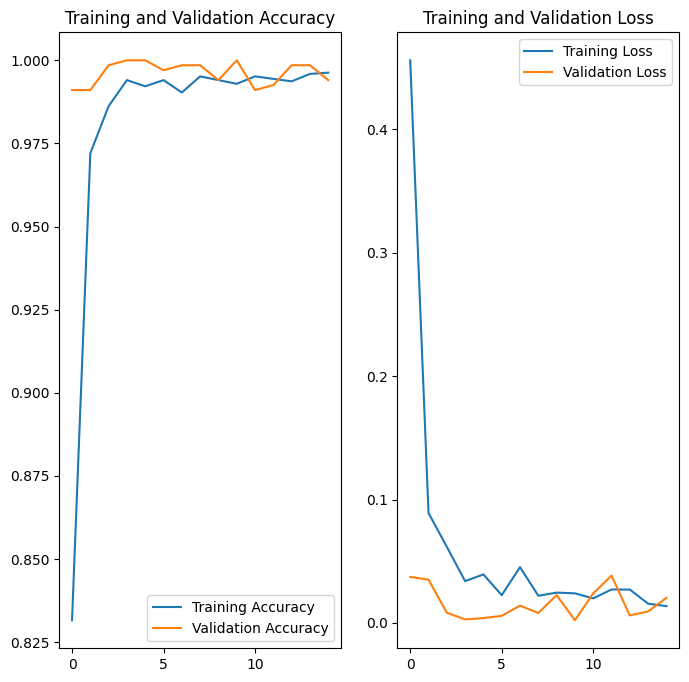

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
from keras.preprocessing import image
# 로컬 이미지 경로 설정
local_image_path = "./85767521-야외에서-옥수수-helminthosporium-또는-turcicum-의-북부-옥수수-잎-병해.jpeg"

# 이미지 불러오기
img = image.load_img(local_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가

# 모델 예측
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# 클래스 이름과 신뢰도 출력
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 13ms/step
This image most likely belongs to Corn___Common_rust with a 99.99 percent confidence.
